## Modules à importer

In [1]:
import math
import scipy
import pickle
import numpy as np
import pandas as pd
import iminuit as im
import ipywidgets as ipw
from variaIa.variaIa import baserate
from importlib import reload
from variaIa.variaIa import stretchevol
from scipy.stats import poisson
from scipy.interpolate import interp1d
from matplotlib.patches import Ellipse
from astropy.cosmology import Planck15 as cdata
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import random

## Définitions pandas, surveys et sélection de l'échantillon à utiliser

In [2]:
d = pd.read_csv('../Data/data_cheat.csv', sep=' ', index_col = 'CID')
d_snf = pd.read_csv('../Data/lssfr_paper_full_sntable.csv',sep=',')

surveys = ['SNF', 'SDSS', 'PS1', 'SNLS', 'HST']

su = ipw.Dropdown(options=surveys,
                  description='Survey:',
                  value = 'PS1')

surv = {'SNF':  d_snf,
        'SDSS': d[d['IDSURVEY'] == 1],
        'PS1':  d[d['IDSURVEY'] == 15],
        'SNLS': d[d['IDSURVEY'] == 4],
        'HST':  d[d['IDSURVEY'].isin([101, 100, 106])]}
    
with open('../Data/zmax_mlim', 'rb') as f:
    z_max = pickle.load(f)

z_max['SNF'] = [10, 10]
z_max['HST'] = [10, 10]

# .loc[d_snf['name'].str.contains('SNF|LSQ|PTF',na=False,regex=True)]

colors = {'SNF': 'orange',
          'SDSS': 'lime',
          'PS1': 'blue',
          'SNLS': 'red',
          'HST': 'purple'}

def set_data(su):
    global dataz, datax
    if su == 'SNF':
        dataz = np.sort(surv[su]['host.zcmb'].values)
        datax = np.sort(surv[su]['salt2.X1'].values)
    else:
        dataz = np.sort(surv[su].zCMB.values)
        datax = np.sort(surv[su].x1.values)
    
int_data = ipw.interactive(set_data, su = su)
display(int_data)

interactive(children=(Dropdown(description='Survey:', index=2, options=('SNF', 'SDSS', 'PS1', 'SNLS', 'HST'), …

## Choix des bins pour les listes de redshifts et de stretch

In [3]:
nb_z = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for z:', continuous_update=False)

def set_bins_z(nb_z):
    global binsz, bordz, countsz
    bordz = np.asarray(np.histogram(dataz, bins = nb_z)[1])
    binsz = np.asarray([[bordz[i],bordz[i+1]] for i in range(len(bordz)-1)]).T
    countsz = np.histogram(dataz, bordz)[0]
    
int_bins_z = ipw.interactive(set_bins_z, nb_z = nb_z)
display(int_bins_z)

nb_x = ipw.IntSlider(min = 3, max = 30, value = 12, description='#bins for x:', continuous_update=False)

def set_bins_x(nb_x):
    global binsx, bordx, countsx
    bordx = np.asarray(np.histogram(datax, bins = nb_x)[1])
    binsx = np.asarray([[bordx[i],bordx[i+1]] for i in range(len(bordx)-1)]).T
    countsx = np.histogram(datax, bordx)[0]
    
int_bins_x = ipw.interactive(set_bins_x, nb_x = nb_x)
display(int_bins_x)

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for z:', max=30, min=3),…

interactive(children=(IntSlider(value=12, continuous_update=False, description='#bins for x:', max=30, min=3),…

## Tracé des redshifts de l'échantillon choisi

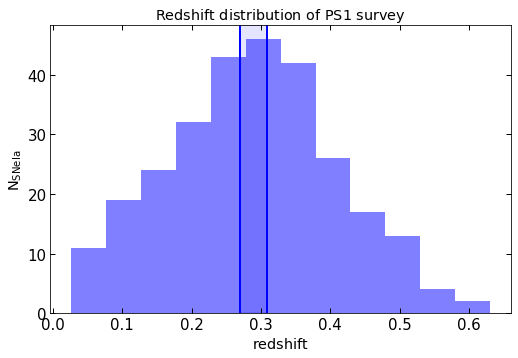

In [4]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

ax.hist(dataz, bins = nb_z.value, color = colors[su.value],
        alpha = .5)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")

ax.vline(z_max[su.value],
         color = colors[su.value], lw=2.0)

ax.axvspan(z_max[su.value][0],
           z_max[su.value][1],
           color = colors[su.value],
           alpha=.1, lw=2.0)

plt.title(r'$\mathrm{Redshift\,\,distribution\,\,of\,\,}$' + str(su.value) +
          r'$\mathrm{\,\,survey}$', fontsize = 'x-large')

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/hist_'
#            + str(su.value) + '_095_cuts.pdf', bbox_inches='tight')

## Définitions des dictionnaires

### $z[:z_{\text{max}}]$, $x_1[:z_{\text{max}}]$, mean et std

In [5]:
zmax_cuts = dict()
z_zcuts = dict()
x1_zcuts = dict()
x1_err_zcuts = dict()
c_zcuts = dict()
c_err_zcuts = dict()

for survey in surveys[1:]:
    zmax_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][1])
    z_zcuts[survey] = surv[survey].zCMB.values[zmax_cuts[survey]]
    x1_zcuts[survey] = surv[survey].x1.values[zmax_cuts[survey]]
    x1_err_zcuts[survey] = surv[survey].x1ERR.values[zmax_cuts[survey]]
    c_zcuts[survey] = surv[survey].c.values[zmax_cuts[survey]]
    c_err_zcuts[survey] = surv[survey].cERR.values[zmax_cuts[survey]]
    
zmax_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values < z_max['SNF'][1])
z_zcuts['SNF'] = surv['SNF']['host.zcmb'].values[zmax_cuts['SNF']]
x1_zcuts['SNF'] = surv['SNF']['salt2.X1'].values[zmax_cuts['SNF']]
x1_err_zcuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmax_cuts['SNF']]
c_zcuts['SNF'] = surv['SNF']['salt2.Color'].values[zmax_cuts['SNF']]
c_err_zcuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zmax_cuts['SNF']]

z_mean = dict()
z_std = dict()
x1_mean = dict()
x1_std = dict()
c_mean = dict()
c_std = dict()

for survey in surveys:
    z_mean[survey] = np.mean(z_zcuts[survey])
    z_std[survey] = np.std(z_zcuts[survey])
    x1_mean[survey] = np.mean(x1_zcuts[survey])
    x1_std[survey] = np.std(x1_zcuts[survey])
    c_mean[survey] = np.mean(c_zcuts[survey])
    c_std[survey] = np.std(c_zcuts[survey])

In [6]:
s = 0
for survey in surveys:
    s += len(z_zcuts[survey])
    print(survey + ' = ', len(z_zcuts[survey]))

print('Sum = ', s)

SNF =  141
SDSS =  167
PS1 =  160
SNLS =  102
HST =  26
Sum =  596


### $[z_{\text{max}}:]$

In [7]:
zmin_cuts = dict()
z_zmincuts = dict()
x1_zmincuts = dict()
x1_err_zmincuts = dict()
c_zmincuts = dict()
c_err_zmincuts = dict()

for survey in surveys[1:]:
    zmin_cuts[survey] = np.where(surv[survey].zCMB.values > z_max[survey][1])
    z_zmincuts[survey] = surv[survey].zCMB.values[zmin_cuts[survey]]
    x1_zmincuts[survey] = surv[survey].x1.values[zmin_cuts[survey]]
    x1_err_zmincuts[survey] = surv[survey].x1ERR.values[zmin_cuts[survey]]
    c_zmincuts[survey] = surv[survey].c.values[zmin_cuts[survey]]
    c_err_zmincuts[survey] = surv[survey].cERR.values[zmin_cuts[survey]]
    
zmin_cuts['SNF'] = np.where(surv['SNF']['host.zcmb'].values > z_max['SNF'][1])
z_zmincuts['SNF'] = surv['SNF']['host.zcmb'].values[zmin_cuts['SNF']]
x1_zmincuts['SNF'] = surv['SNF']['salt2.X1'].values[zmin_cuts['SNF']]
x1_err_zmincuts['SNF'] = surv['SNF']['salt2.X1.err'].values[zmin_cuts['SNF']]
c_zmincuts['SNF'] = surv['SNF']['salt2.Color'].values[zmin_cuts['SNF']]
c_err_zmincuts['SNF'] = surv['SNF']['salt2.Color.err'].values[zmin_cuts['SNF']]

### $[z_{\text{max, inf}}:z_{\text{max, sup}}]$

In [8]:
zbtw_cuts = dict()
z_zbtwcuts = dict()
x1_zbtwcuts = dict()
x1_err_zbtwcuts = dict()
c_zbtwcuts = dict()
c_err_zbtwcuts = dict()

for survey in surveys[1:-1]:
    zbtw_cuts[survey] = np.where((surv[survey].zCMB.values > z_max[survey][0])
                               & (surv[survey].zCMB.values < z_max[survey][1]))
    z_zbtwcuts[survey] = surv[survey].zCMB.values[zbtw_cuts[survey]]
    x1_zbtwcuts[survey] = surv[survey].x1.values[zbtw_cuts[survey]]
    x1_err_zbtwcuts[survey] = surv[survey].x1ERR.values[zbtw_cuts[survey]]
    c_zbtwcuts[survey] = surv[survey].c.values[zbtw_cuts[survey]]
    c_err_zbtwcuts[survey] = surv[survey].cERR.values[zbtw_cuts[survey]]

### $[:z_{\text{inf}}]$, $[z_{\text{sup}}:]$

In [9]:
zinf_cuts = dict()
z_zinfcuts = dict()
x1_zinfcuts = dict()
x1_err_zinfcuts = dict()
c_zinfcuts = dict()
c_err_zinfcuts = dict()

for survey in surveys[1:-1]:
    zinf_cuts[survey] = np.where(surv[survey].zCMB.values < z_max[survey][0])
    z_zinfcuts[survey] = surv[survey].zCMB.values[zinf_cuts[survey]]
    x1_zinfcuts[survey] = surv[survey].x1.values[zinf_cuts[survey]]
    x1_err_zinfcuts[survey] = surv[survey].x1ERR.values[zinf_cuts[survey]]
    c_zinfcuts[survey] = surv[survey].c.values[zinf_cuts[survey]]
    c_err_zinfcuts[survey] = surv[survey].cERR.values[zinf_cuts[survey]]
    
zsup_cuts = dict()
z_zsupcuts = dict()
x1_zsupcuts = dict()
x1_err_zsupcuts = dict()
c_zsupcuts = dict()
c_err_zsupcuts = dict()

for survey in surveys[1:-1]:
    zsup_cuts[survey] = np.where(surv[survey].zCMB.values > z_max[survey][1])
    z_zsupcuts[survey] = surv[survey].zCMB.values[zsup_cuts[survey]]
    x1_zsupcuts[survey] = surv[survey].x1.values[zsup_cuts[survey]]
    x1_err_zsupcuts[survey] = surv[survey].x1ERR.values[zsup_cuts[survey]]
    c_zsupcuts[survey] = surv[survey].c.values[zsup_cuts[survey]]
    c_err_zsupcuts[survey] = surv[survey].cERR.values[zsup_cuts[survey]]

## Tracé du stretch de l'échantillon choisi, coupé à zmax

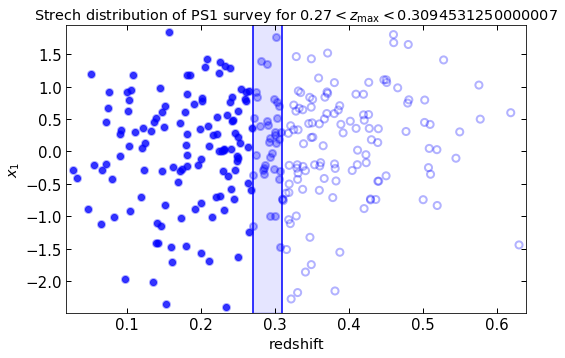

In [13]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha8colors = {'SDSS': (0,1,0,.8),
                'SNLS': (1,0,0,.8),
                'PS1': (0,0,1,.8),
                'HST': (.5,0,.5,.8),
                'SNF': (1,.647,0,.8)}

ax.scatter(z_zinfcuts[su.value],
           x1_zinfcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor=alpha8colors[su.value],
           label=su.value)

ax.scatter(z_zbtwcuts[su.value],
           x1_zbtwcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor=alpha3colors[su.value],
           label=su.value)

ax.scatter(z_zsupcuts[su.value],
           x1_zsupcuts[su.value],
           marker="o", s=50, lw=2,
           edgecolor=alpha3colors[su.value],
           facecolor="None")

ax.vline(z_max[su.value][0],
         color=colors[su.value])
ax.vline(z_max[su.value][1],
         color=colors[su.value])
ax.axvspan(z_max[su.value][0],
           z_max[su.value][1],
           color = colors[su.value],
           alpha=.1, lw=2.0)

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 15,
               top = True, right = True)

ax.set_xlabel(r'$\mathrm{redshift}$', fontsize = 'x-large')
ax.set_ylabel(r'$x_1$', fontsize = 'x-large')

ax.set_xlim(np.min(z_zinfcuts[su.value])-1e-2, np.max(z_zsupcuts[su.value])+1e-2)
ax.set_ylim(np.min(x1_zinfcuts[su.value])-1e-1, np.max(x1_zinfcuts[su.value])+1e-1)

plt.title(r'$\mathrm{Strech\,\,distribution\,\,of\,\,}$'
          + str(su.value)
          + r'$\mathrm{\,\,survey\,\,for\,\,}$'
          + str(z_max[su.value][0])
          + r'$< z_{\mathrm{max}} < $'
          + str(z_max[su.value][1]), fontsize = 'x-large')

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretch_'
#            + str(su.value) + '_spec_cuts.pdf', bbox_inches='tight')

## Tracé des stretchs cut à $z_{\text{max}}$

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

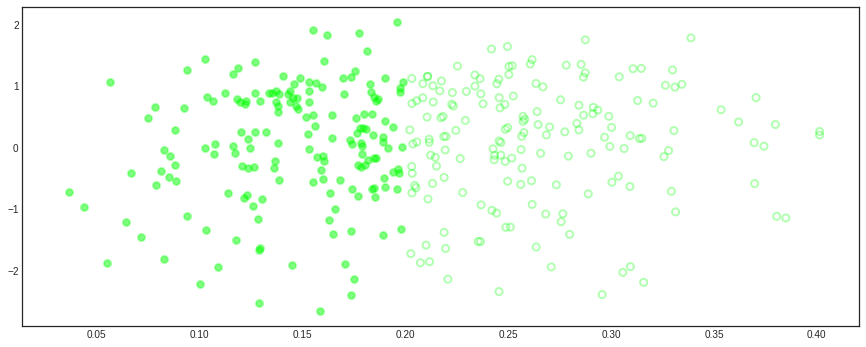

In [16]:
#plt.style.use('dark_background')
plt.style.use('seaborn-white')

plt.figure(figsize = [15,20])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha5colors = {'SDSS': (0,1,0,.5),
                'SNLS': (1,0,0,.5),
                'PS1': (0,0,1,.5),
                'HST': (.5,0,.5,.5),
                'SNF': (1,.647,0,.5)}

for i in range(len(surveys)-2):
    plt.subplot(3, 1, i+1)
    #plt.hist(x1_zcuts[surveys[i]], bins = nb_x.value, color = colors[surveys[i]], alpha = .5)
    
    plt.scatter(z_zcuts[surveys[i+1]],
                x1_zcuts[surveys[i+1]],
                marker="o", s=50, lw=2,
                edgecolor=alpha3colors[surveys[i+1]],
                facecolor=alpha5colors[surveys[i+1]],
                label=surveys[i+1])
    plt.scatter(z_zmincuts[surveys[i+1]],
                x1_zmincuts[surveys[i+1]],
                marker="o", s=50, lw=2,
                edgecolor=alpha3colors[surveys[i+1]],
                facecolor="None")
    plt.axvline(z_max[surveys[i+1]],
                color=colors[surveys[i+1]])
    
    ax = plt.gca()
    ax.tick_params(axis = 'both',
                   direction = 'in',
                   length = 10, width = 3,
                   labelsize = 20,
                   which = 'both',
                   top = True, right = True)

    plt.xlabel(r'$\mathrm{redshift}$', fontsize = 20)
    plt.ylabel(r'$x_1$', fontsize = 20)
    
    plt.title('Strech distribution of ' + surveys[i] + ' survey for $z < $' +
              str(list(zmax.values())[i]), fontsize = 20)

plt.show()

## Définition des dictionnaires généraux : $x_1 < -0.5$ cuts

In [8]:
xmax_cuts = dict()
x1_xcuts = dict()
z_xcuts = dict()

for survey in surveys:
    xmax_cuts[survey] = np.where(x1_zcuts[survey] < -.5)
    x1_xcuts[survey] = x1_zcuts[survey][xmax_cuts[survey]]
    z_xcuts[survey] = z_zcuts[survey][xmax_cuts[survey]]

## Tracé de la fraction de SNe de $x_1 < -0.5$ en fonction de $z_{\text{mean}}$

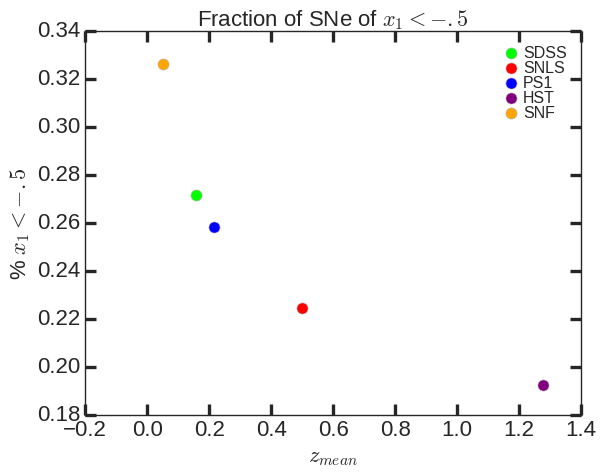

In [9]:
#plt.style.use('dark_background')
plt.style.use(['classic', 'seaborn-white'])

for i in range(5):
    plt.scatter(z_mean[surveys[i]], len(x1_xcuts[surveys[i]])/len(x1_zcuts[surveys[i]]),
                color = colors[surveys[i]], label = surveys[i], marker='o',
                s=100, linewidths=0.5, edgecolors='0.7')
    
ax = plt.gca()
ax.tick_params(axis = 'both',
               direction = 'in',
               length = 10, width = 3,
               labelsize = 20,
               which = 'both',
               top = True, right = True)
plt.xlabel('$z_{mean}$', fontsize = 20)
plt.ylabel('% $x_1 < -.5$', fontsize = 20)

plt.legend(ncol=1, loc='upper right', 
           #bbox_to_anchor=[0.5, 1.1], 
           columnspacing=1.0, labelspacing=0.0,
           handletextpad=0.0, handlelength=1.5,
           fancybox=True, shadow=True)

plt.title('Fraction of SNe of $x_1 < -.5$', fontsize = 20)

plt.show()

## Tracé total : $x_1$, $z$, $z_{\mathrm{cuts}}$, histogrammes

In [27]:
survey = 'SDSS'
np.max(np.histogram(z_zcuts[survey], bins = nb_x.value)[0])

33

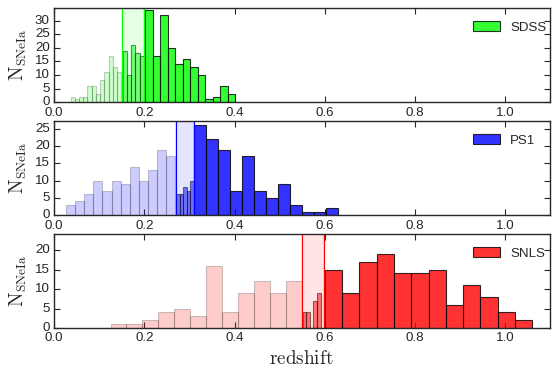

In [40]:
plt.style.use(['classic', 'seaborn-white'])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha5colors = {'SDSS': (0,1,0,.5),
                'SNLS': (1,0,0,.5),
                'PS1': (0,0,1,.5),
                'HST': (.5,0,.5,.5),
                'SNF': (1,.647,0,.5)}

fig = plt.figure(figsize=[8, 5])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

i = 1

for survey in surveys[1:-1]:
    ax = fig.add_subplot(int('31' + str(i)))
    ax.hist(z_zinfcuts[survey], bins = nb_x.value,
            color = colors[survey], alpha = .2)
    ax.hist(z_zbtwcuts[survey], bins = 5,
            color = colors[survey], alpha = .5)
    ax.hist(z_zsupcuts[survey], bins = nb_x.value,
            color = colors[survey], alpha = .8,
            label=survey)
    
    ax.vline(z_max[survey][0],
             color=colors[survey])
    ax.vline(z_max[survey][1],
             color=colors[survey])
    ax.axvspan(z_max[survey][0],
               z_max[survey][1],
               color = colors[survey],
               alpha=.1, lw=2.0)
    
    ax.set_xlim(0, 1.1)
    ax.set_ylim(0, 1.05*np.max(np.histogram(z_zcuts[survey], bins = nb_x.value)[0]))
    
    ax.set_ylabel(r"$\mathrm{N}_\mathrm{SNe Ia}$", fontsize="x-large")
    
    ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)
    
    ax.legend(ncol=1, loc='lower left', fontsize='medium',
          bbox_to_anchor=(0.82, 0.60))
    i += 1

ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/surveys_cuts_x.pdf', bbox_inches='tight')

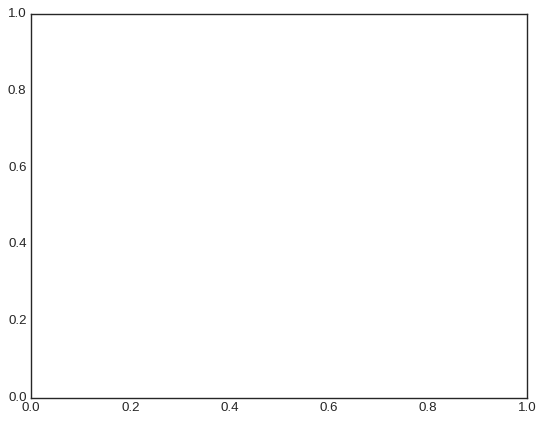

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111)

## Tracé total : $c$, $z$, $z_{\mathrm{cuts}}$, histogrammes

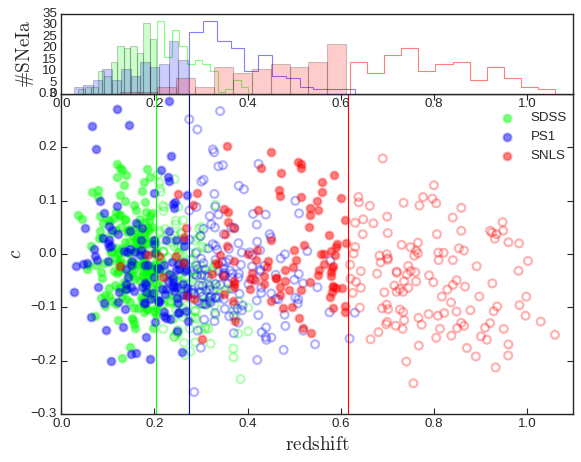

In [13]:
plt.style.use(['classic', 'seaborn-white'])

alpha3colors = {'SDSS': (0,1,0,.3),
                'SNLS': (1,0,0,.3),
                'PS1': (0,0,1,.3),
                'HST': (.5,0,.5,.3),
                'SNF': (1,.647,0,.3)}

alpha5colors = {'SDSS': (0,1,0,.5),
                'SNLS': (1,0,0,.5),
                'PS1': (0,0,1,.5),
                'HST': (.5,0,.5,.5),
                'SNF': (1,.647,0,.5)}

fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])
ax2 = fig.add_axes([0.1, 0.92, 0.8, 0.2])
#ax3 = fig.add_axes([0.9, 0.12, 0.2, 0.8])

prop = dict(marker="o", ms=10, ecolor="0.3", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys[1:-1]:
    ax.scatter(z_zcuts[survey],
               c_zcuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor=alpha5colors[survey],
               label=survey)
    ax.scatter(z_zmincuts[survey],
               c_zmincuts[survey],
               marker="o", s=50, lw=2,
               edgecolor=alpha3colors[survey],
               facecolor="None")
    ax.vline(z_max[survey][1],
             color=colors[survey])
    
    ax2.hist(z_zcuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .2)
    ax2.hist(z_zmincuts[survey], bins = nb_x.value,
             color = colors[survey], alpha = .5, histtype='step')

#    ax3.hist(x1_zmincuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .2)
#    ax3.hist(x1_zcuts[survey], bins = nb_x.value, orientation='horizontal',
#             color = colors[survey], alpha = .5, histtype='step')
    
ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlim(0, 1.1)
ax.set_ylim(-.3, .3)
ax.set_xlabel(r"$\mathrm{redshift}$ ", fontsize="x-large")
ax.set_ylabel(r"$c$ ", fontsize="x-large")

ax2.set_xlim(0, 1.1)
ax2.set_ylabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

#ax3.set_xlabel(r"$\mathrm{\# SNe Ia}$ ", fontsize="x-large")

ax.legend(ncol=1, loc='lower left', fontsize='medium',
          bbox_to_anchor=(0.82, 0.75))

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/surveys_cuts_c.pdf', bbox_inches='tight')

## Tracé des $x_1$, $c$ en fonction du $z$

(-0.4, 0.4)

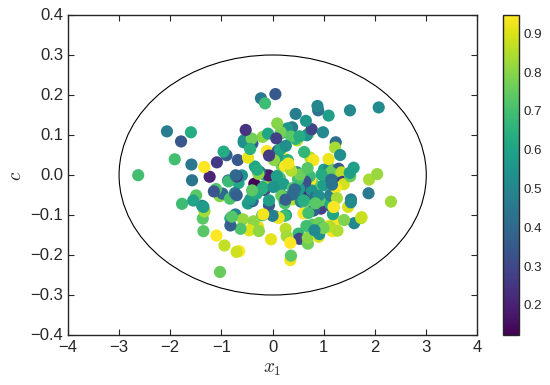

In [71]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])

dgmap = plt.cm.get_cmap('viridis')

survey='SNLS'

ts = ax.scatter(surv[survey].x1,
                surv[survey].c,
                marker='o',
                cmap='viridis',
                c=surv[survey].zCMB, edgecolors="None",
                s=120,
                zorder=2,
                vmax=np.percentile(surv[survey].zCMB, 95))

fig.colorbar(ts)

ax.add_patch(Ellipse((0, 0),
             width=6,
             height=.6,
             ec="black",
             fc="1"))

ax.tick_params(direction='in',
               length=5, width=1,
               labelsize=15,
               top=True, right=True)

ax.set_xlabel(r'$x_1$', fontsize='x-large')
ax.set_ylabel(r'$c$', fontsize='x-large')

#plt.legend(ncol=1, loc='upper left', fontsize='x-large')

ax.set_xlim(-4, 4)
ax.set_ylim(-.4, .4)

## Tracé des $x_{\text{mean}}$ en fonction des $z_{\text{mean}}$

### Définitions pour loi

In [130]:
snf_a = 0.477301
snf_mu_1 = 0.386896
snf_sigma_1 = 0.555105
snf_mu_2 = -1.52109
snf_sigma_2 = 0.518584

def d(z):
    return stretchevol.MockEvol().delta(z)

def age_law_snf(z):
    """Analytical law with snf results"""
    return d(z)*snf_mu_1 + (1-d(z))*(snf_a*snf_mu_1 + (1-snf_a)*snf_mu_2)

### Tracé

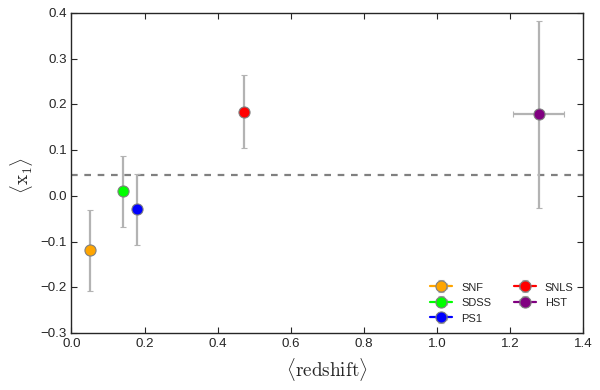

In [134]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)

for survey in surveys:
    ax.errorbar(z_mean[survey], x1_mean[survey],
                xerr = z_std[survey]/np.sqrt(len(z_zcuts[survey])),
                yerr = x1_std[survey]/np.sqrt(len(x1_zcuts[survey])),
                color = colors[survey], label = survey, **prop)
    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(x1_mean.values())), lw=2, ls="--", color="0.5")

#zz = np.linspace(0,1.4,1000)

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
#fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')

## Tracé des $c_{\text{mean}}$ en fonction des $z_{\text{mean}}$

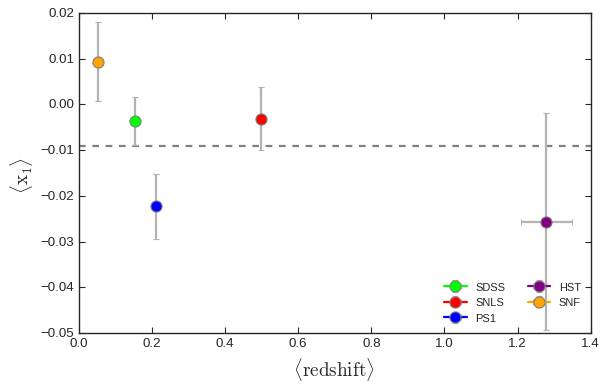

In [80]:
fig = plt.figure(figsize=[8, 5])
ax = fig.add_axes([0.1, 0.12, 0.8, 0.8])


prop = dict(marker="o", ms=10, ecolor="0.7", lw=2, mew=1, mec="0.5", zorder=5)
for i in range(5):
#    if i != 4:
#        continue
    ax.errorbar(list(z_mean.values())[i], list(c_mean.values())[i],
                 xerr = list(z_std.values())[i]/np.sqrt(len(list(z_zcuts.values())[i])),
                 yerr = list(c_std.values())[i]/np.sqrt(len(list(c_zcuts.values())[i])), 
                 color = list(colors.values())[i], label = surveys[i], **prop)

    
#ax.plot(zz, np.mean(x1_z, axis=1), color="0.7", zorder=2, label="BiGaussianModel")
ax.axhline(np.mean(list(c_mean.values())), lw=2, ls="--", color="0.5")

#ax.plot(zz, age_law_snf(zz),
#        color="0.5", lw=2, label='Model')

ax.tick_params(direction = 'in',
               length = 5, width = 1,
               labelsize = 12,
               top = True, right = True)

ax.set_xlabel(r"$\langle\mathrm{redshift} \rangle$ ", fontsize="x-large")
ax.set_ylabel(r"$\langle\mathrm{x}_1 \rangle$ ", fontsize="x-large")

#ax.set_ylim(-0.3, 0.4)

ax.legend(loc="lower right", ncol=2, fontsize="small")

fig=plt.gcf()
fig.savefig('/home/nora/Documents/Thèse/Images/stretchevol_nomodel.pdf')